# Importing libraries

In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# width of the print
np.set_printoptions(linewidth=300)

# Data generation

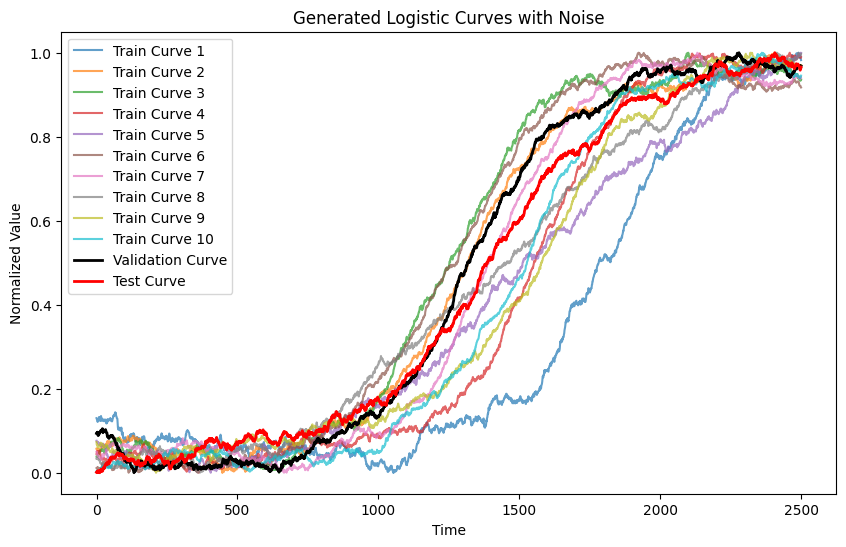

In [2]:

# Logistic function
def logistic_curve(x, L, k, x0, b):
    """Generate a logistic curve."""
    return L / (1 + np.exp(-k * (x - x0))) + b

# Add noise to data
def add_noise(data, noise_level=0.05):
    """Add random noise to the curve."""
    noise = np.random.normal(0, noise_level, len(data))
    cumulative_noise = np.cumsum(np.random.normal(0, 2.5, len(data)))
    return data + noise + cumulative_noise

# Generate curves
def generate_curves(num_curves, t, param_ranges, noise_level=0.05):
    """Generate multiple logistic curves with noise."""
    curves = []
    for _ in range(num_curves):
        L = np.random.uniform(*param_ranges['L'])
        k = np.random.uniform(*param_ranges['k'])
        x0 = np.random.uniform(*param_ranges['x0'])
        b = np.random.uniform(*param_ranges['b'])
        curve = logistic_curve(t, L, k, x0, b)
        curve = add_noise(curve, noise_level)
        curves.append(curve)
    return curves

# Time points
t = np.linspace(0, 2500, 2500)

# Parameter ranges for generating curves
param_ranges = {
    "L": [900, 1300],   # Curve amplitude
    "k": [0.002, 0.006], # Growth rate
    "x0": [1200, 1700], # Midpoint
    "b": [0.01, 0.1]    # Vertical offset
}

# Generate 10 training curves, 1 validation curve, 1 test curve
train_curves = generate_curves(10, t, param_ranges, noise_level=1)
val_curve = generate_curves(1, t, param_ranges, noise_level=1)[0]
test_curve = generate_curves(1, t, param_ranges, noise_level=1)[0]

# Normalize curves
scaler = MinMaxScaler()
train_curves_scaled = [scaler.fit_transform(curve.reshape(-1, 1)).flatten() for curve in train_curves]
val_curve_scaled = scaler.fit_transform(val_curve.reshape(-1, 1)).flatten()
test_curve_scaled = scaler.fit_transform(test_curve.reshape(-1, 1)).flatten()

# Plot the curves for visualization
plt.figure(figsize=(10, 6))
for i, curve in enumerate(train_curves_scaled):
    plt.plot(t, curve, label=f"Train Curve {i+1}", alpha=0.7)
plt.plot(t, val_curve_scaled, label="Validation Curve", color="black", linewidth=2)
plt.plot(t, test_curve_scaled, label="Test Curve", color="red", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.title("Generated Logistic Curves with Noise")
plt.legend()
plt.show()


# Data preparation pytorch *Dataset* and *DataLoader*

In [3]:
class TimeSeriesManyToManyDataset(Dataset):
    def __init__(self, curves, seq_len):
        """
        Parameters:
        - curves: List of 1D numpy arrays (separate time series data).
        - seq_len: Length of input and target sequences.
        """
        self.curves = [torch.tensor(curve, dtype=torch.float32) for curve in curves]
        self.seq_len = seq_len

        # Precompute lengths to handle indexing across multiple curves
        self.cumulative_lengths = np.cumsum([max(0, len(curve) - seq_len) for curve in self.curves])

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, idx):
        """
        Maps a global index to the correct curve and returns:
        - x: Input sequence (seq_len).
        - y: Target sequence (seq_len).
        """
        # Find which curve this index belongs to
        curve_idx = np.searchsorted(self.cumulative_lengths, idx, side="right")
        curve_start_idx = 0 if curve_idx == 0 else self.cumulative_lengths[curve_idx - 1]
        local_idx = idx - curve_start_idx

        # Extract the corresponding sequence
        curve = self.curves[curve_idx]
        x = curve[local_idx : local_idx + self.seq_len]
        y = curve[local_idx + 1 : local_idx + self.seq_len + 1]
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dimension for LSTM


In [76]:
# Sequence length for input/output
sequence_length = 50

# Create datasets for training, validation, and testing
train_dataset = TimeSeriesManyToManyDataset(train_curves_scaled, seq_len=sequence_length)
val_dataset = TimeSeriesManyToManyDataset([val_curve_scaled], seq_len=sequence_length)
test_dataset = TimeSeriesManyToManyDataset([test_curve_scaled], seq_len=sequence_length)


# DataLoader parameters
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset lengths
print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Training Dataset: 24500 samples
Validation Dataset: 2450 samples
Test Dataset: 2450 samples


# Model definition

In [77]:
class ManyToManyLSTMOffset(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(ManyToManyLSTMOffset, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output: (batch_size, seq_len, hidden_dim)
        output = self.fc(lstm_out)  # Linear layer applied at each time step
        return output


In [78]:
# Hyperparameters
input_dim = 1
hidden_dim = 50
output_dim = 1
num_layers = 1
learning_rate = 0.0005


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ManyToManyLSTMOffset(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop with validation

In [79]:

num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for x_batch_train, y_batch_train in tqdm(train_loader, desc=f"T Eph {epoch+1}/{num_epochs}"):
        # torch.Size([32, 50, 1])
        x_batch_train, y_batch_train = x_batch_train.to(device), y_batch_train.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch_train)
        loss = criterion(predictions, y_batch_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_predictions = []
    with torch.no_grad():
        for x_batch_val, y_batch_val in tqdm(val_loader, desc=f"V Eph {epoch+1}/{num_epochs}"):
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            v_predictions = model(x_batch_val)
            val_predictions.extend(v_predictions.cpu().numpy())
            loss = criterion(v_predictions, y_batch_val)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, T Loss: {train_loss:.12f}, V Loss: {val_loss:.12f}")


V Eph 1/50: 100%|██████████| 39/39 [00:00<00:00, 649.87it/s]


Epoch 1/50, T Loss: 0.040506743320, V Loss: 0.008902323077


V Eph 2/50: 100%|██████████| 39/39 [00:00<00:00, 616.86it/s]


Epoch 2/50, T Loss: 0.005389860188, V Loss: 0.004547545467


V Eph 3/50: 100%|██████████| 39/39 [00:00<00:00, 633.24it/s]


Epoch 3/50, T Loss: 0.002913331776, V Loss: 0.002569458747


V Eph 4/50: 100%|██████████| 39/39 [00:00<00:00, 618.16it/s]


Epoch 4/50, T Loss: 0.001664152075, V Loss: 0.001417963447


V Eph 5/50: 100%|██████████| 39/39 [00:00<00:00, 636.68it/s]


Epoch 5/50, T Loss: 0.000902180325, V Loss: 0.000719289212


V Eph 6/50: 100%|██████████| 39/39 [00:00<00:00, 628.24it/s]


Epoch 6/50, T Loss: 0.000464664484, V Loss: 0.000351661202


V Eph 7/50: 100%|██████████| 39/39 [00:00<00:00, 545.14it/s]


Epoch 7/50, T Loss: 0.000225719865, V Loss: 0.000154336147


V Eph 8/50: 100%|██████████| 39/39 [00:00<00:00, 622.37it/s]


Epoch 8/50, T Loss: 0.000092136803, V Loss: 0.000054155362


V Eph 9/50: 100%|██████████| 39/39 [00:00<00:00, 577.19it/s]


Epoch 9/50, T Loss: 0.000032414442, V Loss: 0.000019060255


V Eph 10/50: 100%|██████████| 39/39 [00:00<00:00, 552.91it/s]


Epoch 10/50, T Loss: 0.000014690034, V Loss: 0.000010902386


V Eph 11/50: 100%|██████████| 39/39 [00:00<00:00, 631.75it/s]


Epoch 11/50, T Loss: 0.000010822355, V Loss: 0.000009350383


V Eph 12/50: 100%|██████████| 39/39 [00:00<00:00, 618.02it/s]


Epoch 12/50, T Loss: 0.000009946592, V Loss: 0.000008510751


V Eph 13/50: 100%|██████████| 39/39 [00:00<00:00, 618.76it/s]


Epoch 13/50, T Loss: 0.000009541884, V Loss: 0.000008244161


V Eph 14/50: 100%|██████████| 39/39 [00:00<00:00, 615.33it/s]


Epoch 14/50, T Loss: 0.000009254124, V Loss: 0.000007945694


V Eph 15/50: 100%|██████████| 39/39 [00:00<00:00, 636.28it/s]


Epoch 15/50, T Loss: 0.000009028328, V Loss: 0.000007846233


V Eph 16/50: 100%|██████████| 39/39 [00:00<00:00, 540.53it/s]


Epoch 16/50, T Loss: 0.000008764502, V Loss: 0.000007767827


V Eph 17/50: 100%|██████████| 39/39 [00:00<00:00, 561.92it/s]


Epoch 17/50, T Loss: 0.000008652117, V Loss: 0.000007594099


V Eph 18/50: 100%|██████████| 39/39 [00:00<00:00, 594.18it/s]


Epoch 18/50, T Loss: 0.000008539283, V Loss: 0.000007137760


V Eph 19/50: 100%|██████████| 39/39 [00:00<00:00, 610.99it/s]


Epoch 19/50, T Loss: 0.000008389380, V Loss: 0.000007359947


V Eph 20/50: 100%|██████████| 39/39 [00:00<00:00, 618.29it/s]


Epoch 20/50, T Loss: 0.000008339214, V Loss: 0.000007018659


V Eph 21/50: 100%|██████████| 39/39 [00:00<00:00, 645.19it/s]


Epoch 21/50, T Loss: 0.000008301775, V Loss: 0.000006938112


V Eph 22/50: 100%|██████████| 39/39 [00:00<00:00, 637.27it/s]


Epoch 22/50, T Loss: 0.000008233889, V Loss: 0.000006856036


V Eph 23/50: 100%|██████████| 39/39 [00:00<00:00, 647.06it/s]


Epoch 23/50, T Loss: 0.000008216283, V Loss: 0.000006933173


V Eph 24/50: 100%|██████████| 39/39 [00:00<00:00, 618.57it/s]


Epoch 24/50, T Loss: 0.000008209627, V Loss: 0.000006946158


V Eph 25/50: 100%|██████████| 39/39 [00:00<00:00, 634.67it/s]


Epoch 25/50, T Loss: 0.000008216809, V Loss: 0.000007020282


V Eph 26/50: 100%|██████████| 39/39 [00:00<00:00, 618.18it/s]


Epoch 26/50, T Loss: 0.000008270570, V Loss: 0.000007175452


V Eph 27/50: 100%|██████████| 39/39 [00:00<00:00, 522.85it/s]


Epoch 27/50, T Loss: 0.000008324643, V Loss: 0.000007022162


V Eph 28/50: 100%|██████████| 39/39 [00:00<00:00, 578.53it/s]


Epoch 28/50, T Loss: 0.000008251351, V Loss: 0.000007227257


V Eph 29/50: 100%|██████████| 39/39 [00:00<00:00, 570.90it/s]


Epoch 29/50, T Loss: 0.000008264059, V Loss: 0.000006958244


V Eph 30/50: 100%|██████████| 39/39 [00:00<00:00, 630.32it/s]


Epoch 30/50, T Loss: 0.000008339400, V Loss: 0.000006949469


V Eph 31/50: 100%|██████████| 39/39 [00:00<00:00, 611.17it/s]


Epoch 31/50, T Loss: 0.000008291043, V Loss: 0.000006875467


V Eph 32/50: 100%|██████████| 39/39 [00:00<00:00, 630.11it/s]


Epoch 32/50, T Loss: 0.000008321894, V Loss: 0.000007305177


V Eph 33/50: 100%|██████████| 39/39 [00:00<00:00, 616.18it/s]


Epoch 33/50, T Loss: 0.000008387112, V Loss: 0.000007293678


V Eph 34/50: 100%|██████████| 39/39 [00:00<00:00, 612.48it/s]


Epoch 34/50, T Loss: 0.000008272455, V Loss: 0.000006945260


V Eph 35/50: 100%|██████████| 39/39 [00:00<00:00, 620.79it/s]


Epoch 35/50, T Loss: 0.000008454919, V Loss: 0.000007233204


V Eph 36/50: 100%|██████████| 39/39 [00:00<00:00, 619.03it/s]


Epoch 36/50, T Loss: 0.000008345553, V Loss: 0.000007125027


V Eph 37/50: 100%|██████████| 39/39 [00:00<00:00, 614.04it/s]


Epoch 37/50, T Loss: 0.000008279707, V Loss: 0.000007413630


V Eph 38/50: 100%|██████████| 39/39 [00:00<00:00, 596.79it/s]


Epoch 38/50, T Loss: 0.000008315815, V Loss: 0.000006992684


V Eph 39/50: 100%|██████████| 39/39 [00:00<00:00, 619.63it/s]


Epoch 39/50, T Loss: 0.000008369047, V Loss: 0.000007063242


V Eph 40/50: 100%|██████████| 39/39 [00:00<00:00, 609.36it/s]


Epoch 40/50, T Loss: 0.000008338077, V Loss: 0.000006920282


V Eph 41/50: 100%|██████████| 39/39 [00:00<00:00, 604.20it/s]


Epoch 41/50, T Loss: 0.000008319890, V Loss: 0.000007074600


V Eph 42/50: 100%|██████████| 39/39 [00:00<00:00, 583.83it/s]


Epoch 42/50, T Loss: 0.000008351336, V Loss: 0.000008134240


V Eph 43/50: 100%|██████████| 39/39 [00:00<00:00, 624.44it/s]


Epoch 43/50, T Loss: 0.000008343919, V Loss: 0.000007004239


V Eph 44/50: 100%|██████████| 39/39 [00:00<00:00, 624.71it/s]


Epoch 44/50, T Loss: 0.000008332073, V Loss: 0.000007139048


V Eph 45/50: 100%|██████████| 39/39 [00:00<00:00, 625.52it/s]


Epoch 45/50, T Loss: 0.000008402299, V Loss: 0.000007580501


V Eph 46/50: 100%|██████████| 39/39 [00:00<00:00, 636.55it/s]


Epoch 46/50, T Loss: 0.000008347337, V Loss: 0.000007448904


V Eph 47/50: 100%|██████████| 39/39 [00:00<00:00, 619.83it/s]


Epoch 47/50, T Loss: 0.000008397039, V Loss: 0.000006986605


V Eph 48/50: 100%|██████████| 39/39 [00:00<00:00, 640.93it/s]


Epoch 48/50, T Loss: 0.000008384654, V Loss: 0.000007012180


V Eph 49/50: 100%|██████████| 39/39 [00:00<00:00, 610.17it/s]


Epoch 49/50, T Loss: 0.000008427937, V Loss: 0.000006983653


V Eph 50/50: 100%|██████████| 39/39 [00:00<00:00, 605.81it/s]

Epoch 50/50, T Loss: 0.000008370737, V Loss: 0.000007174739


# Test loop


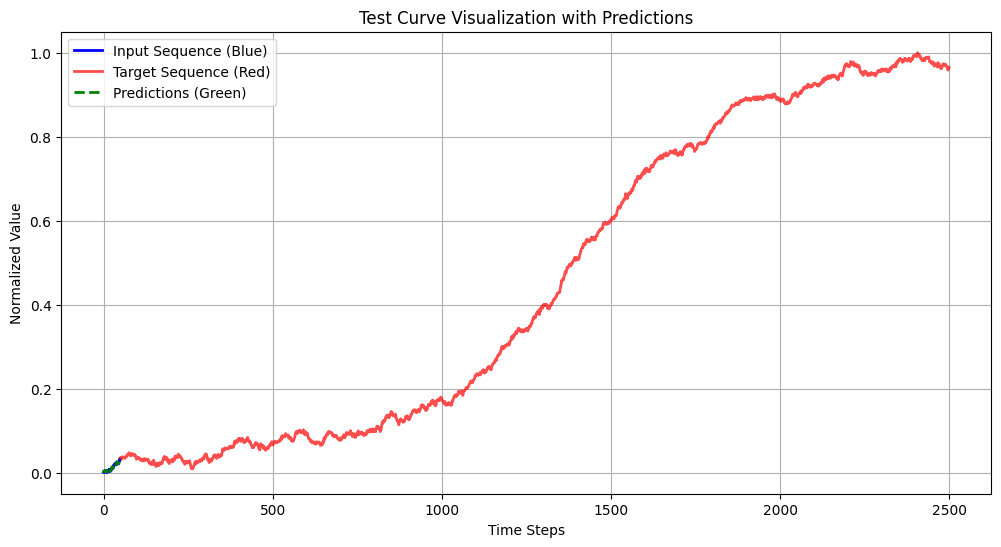

In [80]:

# Prepare input from test curve
x_input = test_curve_scaled[:50]  # First 50 points
x_input_tensor = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # Shape: [1, 50, 1]

# Generate predictions
model.eval()
with torch.no_grad():
    y_pred = model(x_input_tensor)  # Predictions for the input
    y_pred = y_pred.squeeze().cpu().numpy()  # Move predictions to CPU for plotting

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Define full test curve and indices
full_curve = test_curve_scaled
x_indices = np.arange(len(full_curve))

# Plot the test curve
plt.figure(figsize=(12, 6))
plt.plot(x_indices[:50], full_curve[:50], label="Input Sequence (Blue)", color="blue", linewidth=2)  # Input in blue
plt.plot(x_indices[50:], full_curve[50:], label="Target Sequence (Red)", color="red", linewidth=2, alpha=0.7)  # Rest in red
plt.plot(x_indices[:50], y_pred, label="Predictions (Green)", color="green", linestyle="--", linewidth=2)  # Predictions in green

# Add labels and legend
plt.title("Test Curve Visualization with Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()


In [70]:
def get_sequence_from_curve(curve, start_idx, seq_len):
    """
    Extract a sequence of a specified length from the curve starting at a given index.

    Parameters:
    - curve: The complete time series (1D numpy array or list).
    - start_idx: The starting index for the sequence.
    - seq_len: The length of the sequence to extract.

    Returns:
    - The extracted sequence as a numpy array.
    """
    end_idx = start_idx + seq_len
    if end_idx > len(curve):
        raise ValueError(f"End index {end_idx} exceeds curve length {len(curve)}.")
    return curve[start_idx:end_idx]


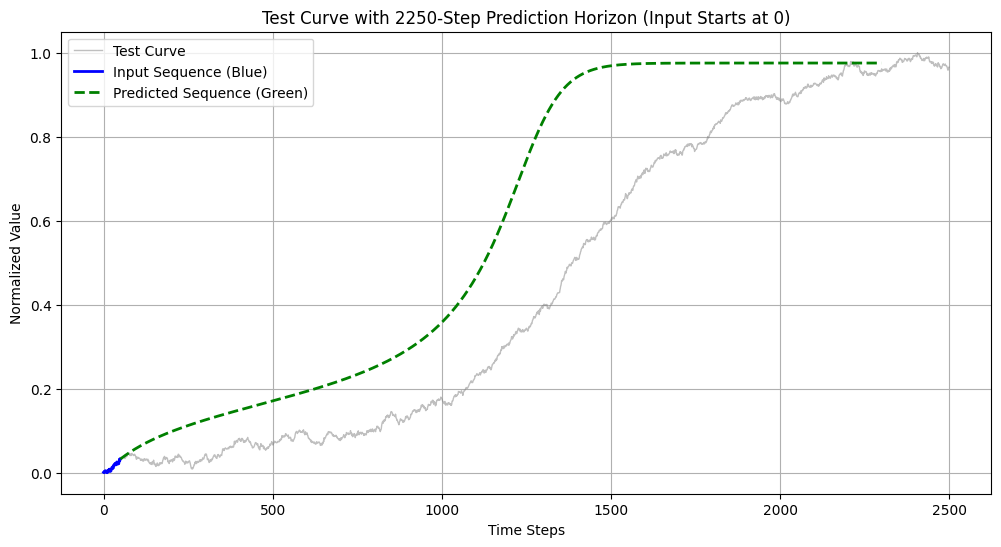

In [87]:

# Parameters for sequence selection
start_idx = 0  # Starting index of the input sequence (choose from anywhere in the curve)
seq_len = 50  # Length of the input sequence
prediction_horizon = 2250  # Number of points to predict

# Get input sequence
x_input = get_sequence_from_curve(test_curve_scaled, start_idx, seq_len)
x_input_tensor = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # Shape: [1, seq_len, 1]

# Initialize a list to store predictions
predictions = []

# Auto-regressive prediction
model.eval()
with torch.no_grad():
    for _ in range(prediction_horizon):
        # Generate prediction
        y_pred = model(x_input_tensor)
        y_next = y_pred[:, -1, :]  # Take the last prediction (next point)
        predictions.append(y_next.item())

        # Update input sequence (remove the first point, append the new prediction)
        x_input_tensor = torch.cat((x_input_tensor[:, 1:, :], y_next.unsqueeze(1)), dim=1)

# Convert predictions to numpy for visualization
predictions = np.array(predictions)

# Visualization
import matplotlib.pyplot as plt

# Define indices for plotting
x_indices = np.arange(len(test_curve_scaled))
input_indices = np.arange(start_idx, start_idx + seq_len)
prediction_indices = np.arange(start_idx + seq_len, start_idx + seq_len + prediction_horizon)

# Plot the test curve
plt.figure(figsize=(12, 6))
plt.plot(x_indices, test_curve_scaled, label="Test Curve", color="gray", linewidth=1, alpha=0.5)  # Full test curve in gray
plt.plot(input_indices, test_curve_scaled[start_idx:start_idx + seq_len], label="Input Sequence (Blue)", color="blue", linewidth=2)  # Input in blue
plt.plot(prediction_indices, predictions, label="Predicted Sequence (Green)", color="green", linestyle="--", linewidth=2)  # Predictions in green

# Add labels and legend
plt.title(f"Test Curve with {prediction_horizon}-Step Prediction Horizon (Input Starts at {start_idx})")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()
